# Задача 9. Hand-crafted graph features

## Задача

- [X] Найти или сгенерировать набор данных для бинарной классификации графов.
- [X] Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- [X] Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества

## Импорты

In [39]:
import numpy as np
import networkx as nx
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from itertools import product

### Генерация синтетических данных графов

In [40]:
def generate_synthetic_graph_data(num_samples=100, max_nodes=15):
    graphs = []
    labels = []
    
    for _ in range(num_samples):
        # Класс 0: Графы с низкой плотностью (деревья или почти деревья)
        if np.random.rand() < 0.5:
            n = np.random.randint(5, max_nodes+1)  # Случайное число узлов
            G = nx.gnm_random_graph(n, n-1 + np.random.randint(0, 2))  # Граф с n узлами и n-1 или n рёбрами
            labels.append(0)

        # Класс 1: Графы с высокой плотностью (почти полные графы)
        else:
            n = np.random.randint(5, max_nodes+1)
            max_edges = n*(n-1)//2  # Максимальное возможное число рёбер
            m = max_edges - np.random.randint(0, n)  # Число рёбер близко к максимальному
            G = nx.gnm_random_graph(n, m)
            labels.append(1)
        
        for u, v in G.edges():
            G.edges[u, v]['weight'] = np.random.rand()
        graphs.append(G)
    
    return graphs, np.array(labels)

graphs, y = generate_synthetic_graph_data(num_samples=200)
X_train, X_test, y_train, y_test = train_test_split(graphs, y, test_size=0.3, random_state=42)

### Вычисление вектора кратчайших путей

In [41]:
def compute_shortest_path_vector(G, max_path_length=10):
    path_counts = np.zeros(max_path_length + 1, dtype=int)
    
    paths = dict(nx.shortest_path_length(G, weight='weight'))
    
    for source in paths:
        for target, length in paths[source].items():
            if source != target and length <= max_path_length:
                path_counts[int(np.floor(length))] += 1
    
    n = G.number_of_nodes()
    if n > 1:
        path_counts = path_counts / (n * (n - 1))
    
    return path_counts

### Ядровая функция на основе кратчайших путей

In [42]:
def shortest_path_kernel(train_graphs, test_graphs, max_path_length=10):
    train_vectors = np.array([compute_shortest_path_vector(G, max_path_length) for G in train_graphs])
    
    K_train = np.dot(train_vectors, train_vectors.T)
    
    if test_graphs is None:
        return K_train, None
    
    test_vectors = np.array([compute_shortest_path_vector(G, max_path_length) for G in test_graphs])
    K_test = np.dot(test_vectors, train_vectors.T)
    
    return K_train, K_test

K_train, K_test = shortest_path_kernel(X_train, X_test)

### Обучение SVM с подбором гиперпараметров

In [43]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['precomputed']
}

svm = GridSearchCV(
    SVC(probability=True),
    param_grid, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
svm.fit(K_train, y_train)

print("Лучшие параметры:", svm.best_params_)
print("Лучшая точность на кросс-валидации:", svm.best_score_)

Лучшие параметры: {'C': 100, 'gamma': 'scale', 'kernel': 'precomputed'}
Лучшая точность на кросс-валидации: 0.9785714285714286


### Оценка модели на тестовых данных

In [44]:
K_train_best, K_test_best = shortest_path_kernel(X_train, X_test)
best_svm = svm.best_estimator_

y_pred = best_svm.predict(K_test_best)
y_prob = best_svm.predict_proba(K_test_best)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nМетрики качества на тестовом наборе:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Матрица ошибок:")
print(conf_matrix)


Метрики качества на тестовом наборе:
Accuracy: 0.9833
F1-score: 0.9859
ROC-AUC: 0.9800
Матрица ошибок:
[[24  1]
 [ 0 35]]


### Визуализация примеров графов

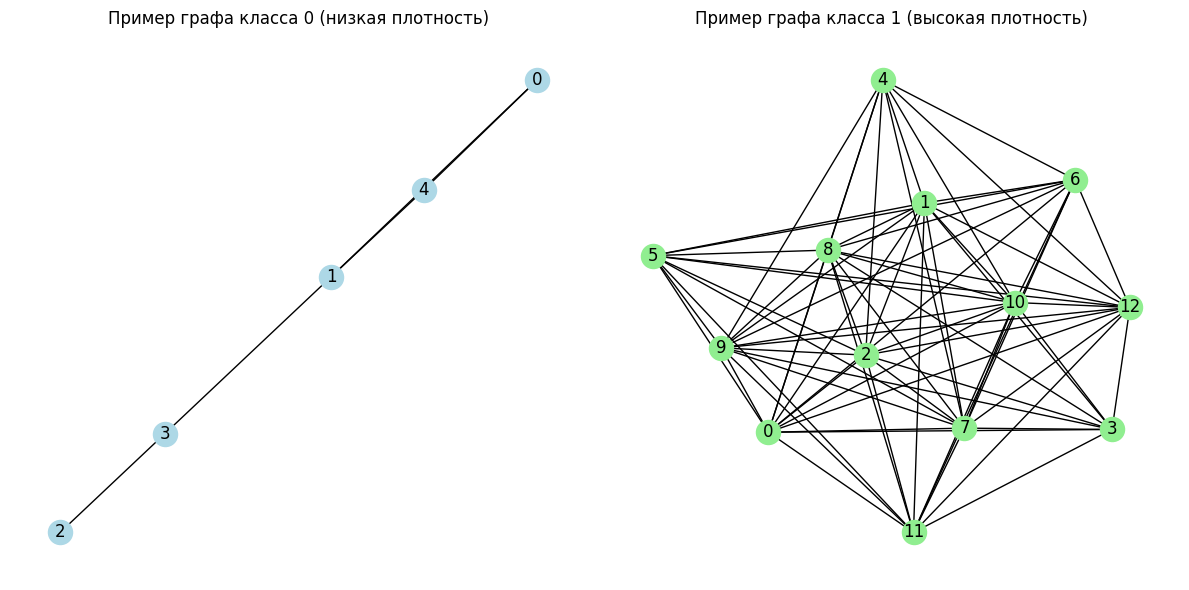

In [45]:
plt.figure(figsize=(12, 6))

# Графы класса 0 (низкая плотность)
plt.subplot(1, 2, 1)
class0_graphs = [G for G, label in zip(X_train, y_train) if label == 0]
nx.draw(class0_graphs[0], with_labels=True, node_color='lightblue')
plt.title("Пример графа класса 0 (низкая плотность)")

# Графы класса 1 (высокая плотность)
plt.subplot(1, 2, 2)
class1_graphs = [G for G, label in zip(X_train, y_train) if label == 1]
nx.draw(class1_graphs[0], with_labels=True, node_color='lightgreen')
plt.title("Пример графа класса 1 (высокая плотность)")

plt.tight_layout()
plt.show()

## Итоги

В ходе работы было проделано следующее:
1. Созданы два класса графов: с низкой и высокой плотностью
2. Для каждого графа вычислен вектор распределения длин кратчайших путей
3. Использовано линейное ядро на векторах кратчайших путей
4. Была обучена SVC модель с подбором гипепараметров (лучшими оказались 'C': 0.1, 'gamma': 'scale', 'kernel': 'precomputed')
5. Были вычислены такие матрики качества как F1-score и ROC-AUC, а также матрица ошибок
6. По итогу, модель была обучена с точностью 0.9333